# TIE Reconstruction Template
In this notebook we demonstrate solving the transport of intensity equation (TIE) and finding magnetic induction from an experimental through focal series (tfs) of TEM images. For more information please check out our [wiki/documentation pages](https://pylorentztem.readthedocs.io/en/latest/). 

If you have never used a Jupyter Notebook before we recommend familiarizing yourself with the [notebook basics](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html). While Python knowledge is not strictly required for running PyLorentz code, a certain familiarity is helpful for understanding how to modify the examples to suit your needs. 

This notebook is ready to be run as-is. The first time, however, you will need to download the example data. This can be done through the notebook and is demonstrated below. Cells can be executed by selecting and pressing ``shift + enter``, and you can proceed with running all of the cells in order. The python docstrings for these functions can be found on the wiki, but are also viewable in Jupyter. E.g. for the TIE() function, executing a cell containing: `?TIE` will pull up the documentation for that function. 

All of the features available in this notebook are also available in the TIE GUI, which additionally contains processes for aligning experimental datasets. For details on running that please refer to the README in the ``Pylorentz/GUI/`` directory. 
  
Authors: Arthur McCray, CD Phatak  
V1.0, ANL, July 2020

### Importing the necessary modules

In [ ]:
# %matplotlib widget
# from PyLorentz.utils.microscopes import Microscope
# from PyLorentz.utils.TIE_helper import *
# from PyLorentz.tie.TIE_reconstruct import TIE

# from PyLorentz.io.io import load_data
# from PyLorentz.visualize import show_im, show_stack, show_2D

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [147]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from PyLorentz.io.read import read_image
from PyLorentz.io.write import write_tif, write_json
from PyLorentz.dataset.defocused_dataset import DefocusedDataset

from PyLorentz.visualize.show import show_im, show_stack
from PyLorentz.visualize.vector_show import show_2D
from PyLorentz.tie.tie import TIE


This first section shows how to download example data from the [Materials Data Facility](https://doi.org/10.18126/z9tc-i8bf). This experimental dataset contains a full through focus series (tfs) of an artificial spin ice structure with the sample in both flipped and unflipped orientations. 

There seems to be a bug(s) in the mdf_forge package, and downloading in-notebook currently isn't working. For now we recoomend downloading the data with globus from the [data page](https://doi.org/10.18126/z9tc-i8bf). Click "Globus" under "Get the Data" and download using their online app. Place the downloaded `cphatak_pytie_example_v1.1` in the `PyLorentz/Examples/` directory.


#### old method
If the mdf-forge package is working, you will be able to run the following cell and download the data directly. 
The files will be placed in `Examples/cphatak_pytie_example_v1.1/`, and you only need to run this following cell the first time through the notebook. Incidentally there seems to be a bug in the mdf-forge package and the progress bar doesn't move, but it generally takes ~5-10 minutes for the download depending on your internet speed. 

If you are having trouble downloading the data please make sure 
* You have a Globus endpoint on your computer
* You have Globus Connect running

If it still isn't working you can download the data with globus from the [data page](https://doi.org/10.18126/z9tc-i8bf). Click "Globus" under "Get the Data" and download using their online app. 

In [ ]:
### buggy, download directly instead
# from mdf_forge import Forge
# mdf = Forge()

# # Match the dataset by title and only collect "dataset" resource types
# res = mdf.match_resource_types('dataset').match_titles('pytie').search()

# # Download the data using Globus
# mdf.globus_download(res, download_datasets=True)

## Loading the data into PyTIE
Now that we have our data on the computer, we need to load it into PyTIE with the `load_data()` function. We set a few parameters here: 

- path (str): We specify the filepath as the one created with the example data.
- fls_file (str): The name of the .fls file, which itself contains the image filenames and defocus values. 
- flip_fls_file (str): We explicitly show that there isn't a flip fls file, though this could be omitted as it's the default value. 
- al_file (str): The name of the aligned image file. 
- flip (bool): Whether or not there is a flip tfs along with the unflip. 

In [3]:
aligned_file = "./data/cphatak_PyLorentz_example_v2/aligned_stack.tif"
aligned_flip_file = "./data/cphatak_PyLorentz_example_v2/aligned_flip_stack.tif"
tfs_mdata_file = "./data/cphatak_PyLorentz_example_v2/tfs_mdatap.json"
dd = DefocusedDataset.load(
    aligned_file=aligned_file,
    aligned_flip_file=aligned_flip_file,
    metadata_file=tfs_mdata_file,
)

dd.preprocess(fast=True) # hotpix filtering, masking,

Filtering hot/dead pixels


100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


#### legacy

In [ ]:
aligned_file = "./data/cphatak_pytie_example_v1.1/d1_full_align.tif"
data_loc = "./data/cphatak_pytie_example_v1.1/"
fls_filename = "dataset1.fls"

tfs_mdata_file = "./data/cphatak_PyLorentz_example_v2/tfs_mdata.json"
dd = DefocusedDataset.load(
    aligned_file=aligned_file,
    legacy_data_loc=data_loc,
    legacy_fls_filename=fls_filename,
)

dd.preprocess(fast=True) # hotpix filtering, masking,


#### Now view the masked infocus image.


In [ ]:
show_im(dd.infocus, title="Averaged in-focus image", scale=dd.scale, cbar_title="intensity")

interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

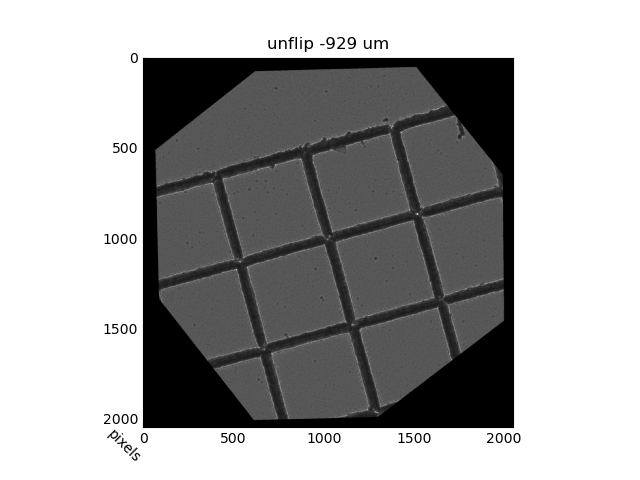

In [4]:
full_titles = [f"{fl} {df/1e3:.0f} um" for fl, df in zip(['unflip']*dd.len_tfs + ['flip']*dd.len_tfs, dd.full_defvals)]
show_stack(dd.full_stack, titles=full_titles)

## Select a smaller image size (optional)
There may be times when you would want to only reconstruct part of an image, e.g. because a window edge introduces a high-contrast edge that interferes with the reconstruction. Although this is available here in the Jupyter notebook, it is somewhat finnicky. We recommend using the GUI if you want easier region selection, as it also allows for rotating the images. 
  
* If you choose a non-square subregion, the results are no longer quantitative. Qualitatively they will appear correct except beyond aspect ratios of ~3:1, where Fourier edge effects become more prominent. These can be reduced by symmetrizing the image.  
* Click to place the upper left and lower right corner of the region. You can also delete one or both of the corners before placing them, but this can be laggy. 
* Exiting select_ROI() (with `esc`) while one or both points are selected will reset the ROI to the full image. This can also be done with ptie.reset_crop(). 
* The corners of the ROI are stored in ptie.crop, and can be set individually in pixels, e.g. >>ptie.crop["left"] = 100 

Interactive ROI selection:
	Right click | move closest corner to mouse position
	'j'/'k'     | rotate the image, shift + 'j'/'k' to increase step size
	'n'/'m'     | grow/shrink the ROI, shift + 'n'/'m' to increase step size
	arrow keys  | move the ROI, + shift to increase step size
	'c'         | center the ROI on the middle of the image
	's'         | make the ROI square
	shift+'r'         | reset the ROI to the starting conditions
	shift+'f'   | restore the full image with zero rotation
	'esc'       | save transformations and exit
If display is not responding, try clicking on the image and ensuring %matplotlib widget
Starting parameters: 


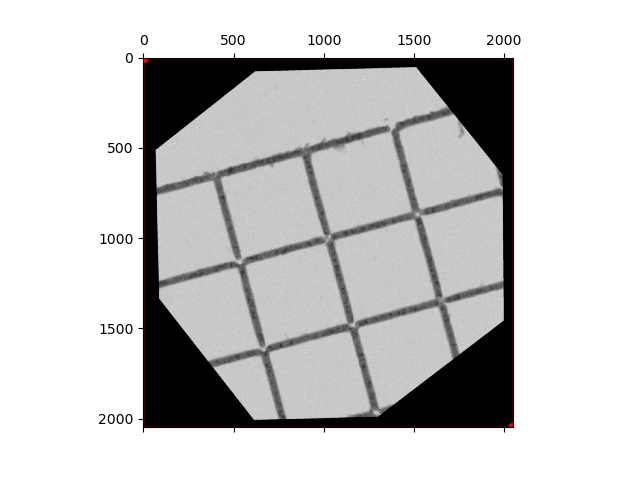

Current parameters:


setting transformations: ( 240,  240), (1808, 1808) | Dimensions (h x w): 1568 x 1568
{'rotation': 0, 'top': 240, 'bottom': 1808, 'left': 240, 'right': 1808}
Final image dimensions (h x w): 1568 x 1568
Cropping can be returned to the full image by running dd.reset_transformations()


In [5]:
# requires matplotlib widget
dd.select_ROI()
# will default to infocus image, but can input a specific image, e.g. dd.select_ROI(dd._orig_imstack[0]), must be of original input size

In [ ]:
# can also set manually with a dictionary
# values will be overwritten with new
dd.transformations = {"rotation": -15}

In [10]:
# Once transforms set, then apply
# have to do this in seperate cell due to notebook/matplotlib limitations
dd.apply_transforms()

Finished transformations...


interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

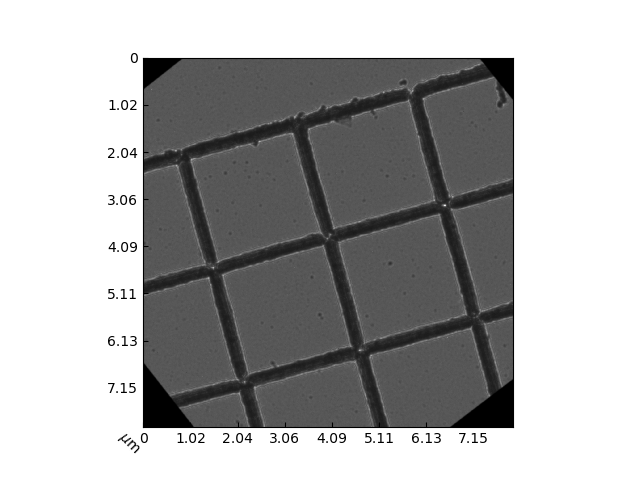

In [7]:
show_stack(dd.full_stack, scale=dd.scale)#, titles=full_titles)

## The actual phase reconstruction
Here we perform the TIE reconstruction. The following parameters are set: 

* Set which focus values you want to use with index i 
* images will be saved as /dataloc/images/dataname_focusval_imagename.tif
* if you want to symmetrize the images set sym = True. 
    - This is primarily helpful if reconstructing images where one or more dimensions is an nearly prime number of pixels or if the aspect ratio of the reconstructed region is far from 1. 
* if you want to run with a Tikhonov frequency
    - qc = XX, allows you to input a frequency value in 1/nm
    - qc = None and it will run without a filter
* Save options:  
    - True    -- saves all images results directory
    - 'b'     -- saves 'color_b', 'bxt', 'byt'
    - 'color' -- saves just 'color_b'
    - False   -- Does not save images, but they can still be viewed in the notebook
    - If any images are saved, a dataname_params.txt file will be saved as well giving reconstruction parameters. 

In [11]:
print(f'Defocus values (um): ± {np.round(dd.defvals_index, -4)/1e3}')
print('Use defocus_index  =     0 ,  1 ,  2')

Defocus values (um): ± [200. 400. 930.]
Use defocus_index  =     0 ,  1 ,  2


In [104]:
tie = TIE(dd)

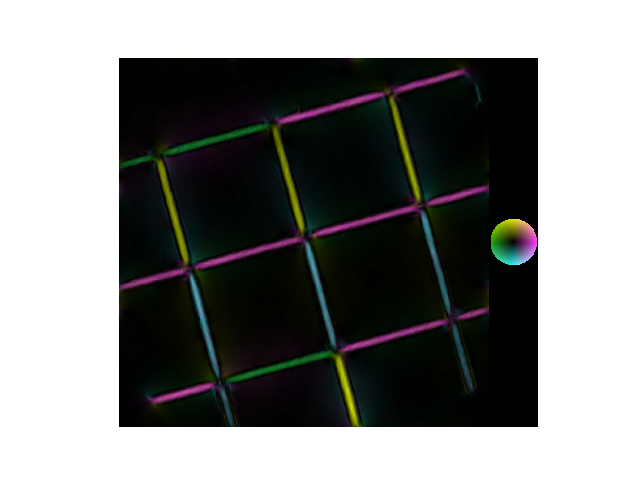

In [119]:
show_2D(tie.By, tie.Bx, cmap='4fold')

## Viewing the images
You can of course just look at the data where it's saved, but if you don't want to save it and move it to a local computer you can view the images here, as they're all in the results dictionary. 
* Results: 
    - 'byt' : y-component of integrated magnetic induction,
    - 'bxt' : x-component of integrated magnetic induction,
    - 'bbt' : magnitude of integrated magnetic induction, 
    - 'phase_b' : magnetic phase shift (radians),
    - 'phase_e' : electrostatic phase shift (if using flip stack) (radians),
    - 'dIdZ_b' : intensity derivative for calculating phase_m, (useful for troubleshooting)
    - 'dIdZ_e' : intensity derivative for calculating phase_e (if using flip stack), 
    - 'color_b' : RGB image of magnetic induction,
    - 'inf_im' : the in-focus image

Saving: d:\code\PyLorentz\Examples\data\cphatak_PyLorentz_example_v2\TIE_outputs\240706-112604_TIE_929um_B.png


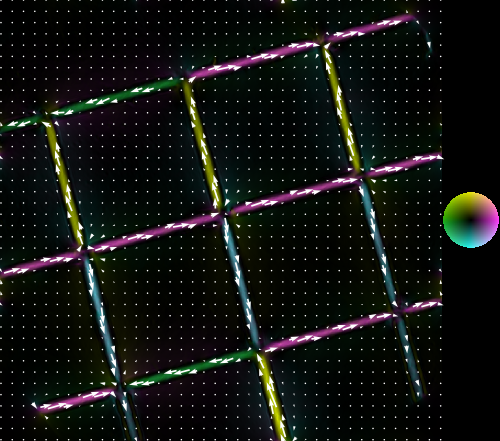

In [146]:
fname = f"{tie._save_name}_{tie._fmt_defocus(tie.defval)}_B.png"
show_2D(tie.By,
        tie.Bx,
        num_arrows=40,
        arrow_size=2,
        arrow_width=6,
        cmap="4fold",
        save=tie.save_dir / fname
        )

In [ ]:
show_im(results['phase_b'], title='magnetic phase shift', scale=ptie.scale,
        cbar_title="Radians")

In [ ]:
show_im(results['phase_e'], 'electrostatic phase shift',scale=ptie.scale,
        cbar_title="Radians")

Show the integrated induction vector map with a variety of color schemes: 
- Most of the colormaps are found in the [colorcet package](https://colorcet.holoviz.org/user_guide/Continuous.html#cyclic-colormaps)
    - "4fold"
    - "legacy4fold"
    - "hsv" (equivalent to "sixfold", default)
    - "legacyhsv" (equivalent to "purehsv", not a great choice for most situations)
    - "iso" (a 4-fold isoluminscent colormap)  

You can also pass a colormap object in to the cmap argument


In [ ]:
show_2D(results['bxt'], results['byt'], title="Magnetic induction with four-fold colormap",
        cmap='default')


Show a vector plot of the magnetic induction over the colormap image. The arrows size is fixed so you will have to zoom in to see them. There are a few parameters required to have the vectormap look good. 
- a (int): Number of arrows to show in the x and y directions
- l (float): Scale factor of arrows. Larger l -> shorter arrows. 
- w (float): Width scaling of arrows.
- title (str): (*optional*) Title for plot. Default None. 
- color (bool): (*optional*) Whether or not to show a colormap underneath the arrow plot.
- hsv (bool): (*optional*) Only relevant if color == True. Whether to use an hsv or 4-fold colorwheel in the color image. 
- origin (str): (*optional*) Control image orientation. 
- save (str): (*optional*) Path to save the figure. 

In [ ]:
show_2D(results['bxt'], results['byt'], a=40, l=1, w=4, title='Arrow overlay image', color=True, cmap='default',
        origin='upper')#, save = ptie.data_loc+'images/arrow_colormap.png')

### Single Image Reconstruction (SITIE)
Uniformly thin magnetic samples can be reconstructed from a single defocused image if their only source of contrast is magnetic Fresnel contrast. The previous example showed images of an island structure for which that is not the case, and we require two TFS to reconstruct the phase. 

Here we demonstrate the SITIE method for a simulated image of Neel type skyrmions. 

--- end notebook ---